In [1]:
#Pytorch for vision classification
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np

import time
import os
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/mrblack/pyenvs/venv_signLanguage/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [ ]:
#data from google drive:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#package for splitting the dataset
# !pip install split-folders[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import splitfolders

# input_folder = '/content/drive/MyDrive/Datasets/SignLanguageDataset'
# splitfolders.ratio(input_folder, output="/content/drive/MyDrive/Datasets/SignLanguageDatasetDivided",
#                    seed=42, ratio=(.7,.3),
#                    group_prefix=None)

In [2]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [3]:
#There is no val, it is only train and test

data_dir = os.path.expanduser('~') + '/Datasets/SignLanguageLetteres'
sets = ['train', 'val']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in sets}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=0)
                  for x in sets} 

dataset_sizes = {x: len(image_datasets[x]) for x in sets}
class_names = image_datasets['train'].classes
print(class_names)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mrblack/Datasets/SignLanguageLetteres/train'

In [ ]:
batch_size = 4
# num_epochs = 1
# learning_rate = 0.01

In [ ]:
train_loader = DataLoader(dataset=image_datasets['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=image_datasets['val'], batch_size=batch_size, shuffle=False)

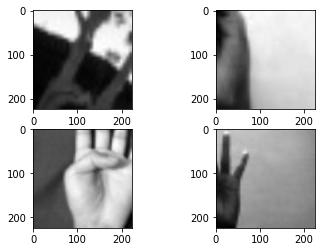

torch.Size([4, 3, 224, 224])

In [ ]:
## Plotting some images of the dataset:
sign_example = iter(train_loader)
sign_data, sign_label = sign_example.next()

for i in range(4):
  plt.subplot(2,2, i+1)
  plt.imshow(sign_data[i][0], cmap='gray')
plt.show()
sign_data.shape
# image shape = (3, 224, 224)
# the 4 is for batch size

Another way of showing the images: 

[thanks to transfer learning guide from pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

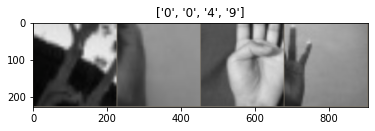

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

out = torchvision.utils.make_grid(sign_data)
imshow(out, title=[class_names[x] for x in sign_label])

In [ ]:
# image shape = (3, 224, 224)
#Formula for CNN = (W-F + 2P) / S + 1
# W: input width
# F: Filter Size
# P: Padding
# S: Stride
# 224 - F + 2*(0) / 1 + 1
class SignNet(nn.Module):
  def __init__(self):
    super(SignNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5) # (224 - 5 + 2*(0)) / 1 + 1 =220 -> 6, 220, 220
    self.pool1 = nn.MaxPool2d(2,2) #220 / 2 = 110
    self.conv2 = nn.Conv2d(6, 16, 5)  # (110 - 5 + 2*(0)) / 1 + 1 = 106 -> 16, 106, 106
    self.pool2 = nn.MaxPool2d(2,2) #106 / 2 = 53 - > 16, 53, 53 
    self.fc1 = nn.Linear(16*53*53, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 11) # 11 classes

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, 16*53*53) #Flatten
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return x


model = SignNet().to(device) #in case I'm training on the GPU
# x = model.forward
# print(x)
print(model)

SignNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=11, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# n_total_steps = len(train_loader)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs ,batch_size=4):
  # best_model_wts = copy.deepcopy(model.state_dict())
  # best_acc = 0.0
  n_total_steps = len(train_loader)
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

      images = images.to(device)
      labels = labels.to(device)

      #Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
      wandb.log({"loss": loss}) ########## weight and biases

      #Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # print('here')
      if (i+1) % 2000 == 0:
        print(f'Epoch [{epoch + 1}/ {num_epochs}], Step [{i+1} / {n_total_steps}], Loss: {loss.item():.4f}')


def eval_model(test_loader, model, batch_size=4):
  with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(11)] # you have 10 classes 0 to 9 and the unknown
        n_class_samples = [0 for i in range(11)]

        for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)

          _, predicted = torch.max(outputs,1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()
          # print(len(labels))
          for i in range(len(labels)): #range(len(labels)): #range(batch_size)
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
              n_class_correct[label] += 1

            n_class_samples[label] +=1

        acc= 100.0 * n_correct / n_samples
        print(f'Accuracy of the model {acc} %')


        for i in range(11): #number of classes
          acc = 100.0 * n_class_correct[i] / n_class_samples[i]
          print(f'Accuracy: {class_names[i]} : {acc} %')

In [ ]:
train_model(model, train_loader, criterion, optimizer, 1, batch_size=4)

Epoch [1/ 1], Step [2000 / 2889], Loss: 2.3956


In [ ]:
File_Path = '/content/drive/MyDrive/Datasets/DL_Models/sign_model.pth'

# torch.save(model.state_dict(), File_Path)

In [ ]:
loaded_model = model()
loaded_model.load_state_dict(torch.load(File_Path))

In [ ]:
eval_model(test_loader, model)

In [ ]:
## Fine tuning the network using mobilenet_v2 (training the whole model)

model_2 = models.mobilenet_v2(pretrained=True)
num_features_2 = model_2.fc.in_features
model_2.fc = nn.Linear(num_features_2, 11) #11 classes
model_2.to(device)



print(num_features_2)
print(model_2)

In [ ]:
## Fine tuning the network using resnet18 (training the whole model)

model_3 = models.resnet18(pretrained=True)
num_features_3 = model_3.fc.in_features
model_3.fc = nn.Linear(num_features_3, 11)

model_3.to(device)

print(num_features_3)
print(model_3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

512
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [ ]:
## Freezing the layers at the begining at only train the last layers
## Much faster
model_4 = models.resnet18(pretrained=True)
for param in model_4.parameters():
  param.requires_grad = False

num_features_4 = model_4.fc.in_features
model_4.fc = nn.Linear(num_features_4, 11) #11 classes
model_4.to(device)



print(num_features_4)
print(model_4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

512
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #every 7 epochs, learning rate is multiplied by 0.1

In [ ]:
#model 3 training (pretrained using resnet18)
# train_model(model_3, train_loader, criterion, optimizer, 1, batch_size=4)

In [ ]:
#model 4 training (pretrained using resnet18) - Freeze
# train_model(model_4, train_loader, criterion, optimizer, 1, batch_size=4)

Epoch [1/ 1], Step [2000 / 2889], Loss: 2.1943


In [ ]:
File_Path = '/content/drive/MyDrive/Datasets/DL_Models/sign_model_100.pth'

# torch.save(model_4.state_dict(), File_Path)

In [ ]:
# Loading the model

model = model_4
model.load_state_dict(torch.load(File_Path))
# model.eval()

<All keys matched successfully>

In [ ]:
!pip install wandb
import wandb
wandb.login
wandb.init(project="Hand-Gestures", entity="ahmedharbi")
# Copy
# wandb.config = {
#   "learning_rate": 0.001,
#   "epochs": 100,
#   "batch_size": 128
# }

# wandb.log({"loss": loss})

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 26.0 MB/s 
     |████████████████████████████████| 168 kB 72.2 MB/s 
     |████████████████████████████████| 182 kB 64.9 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 166 kB 74.3 MB/s 
     |████████████████████████████████| 166 kB 72.6 MB/s 
     |████████████████████████████████| 162 kB 76.5 MB/s 
     |████████████████████████████████| 162 kB 75.1 MB/s 
     |████████████████████████████████| 158 kB 78.2 MB/s 
     |████████████████████████████████| 157 kB 78.4 MB/s 
     |████████████████████████████████| 157 kB 78.7 MB/s 
     |████████████████████████████████| 157 kB 78.5 MB/s 
     |████████████████████████████████| 157 kB 78.0 MB/s 
     |████████████████████████████████| 157 kB 78.6 MB/s 
     |████████████████████████████████| 157 kB 79.6 MB/s 
     |███████████████████████████

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
model.train()
train_model(model, train_loader, criterion, optimizer, 20, batch_size=32)

Epoch [1/ 20], Step [2000 / 2889], Loss: 1.1563
Epoch [2/ 20], Step [2000 / 2889], Loss: 0.7588
Epoch [3/ 20], Step [2000 / 2889], Loss: 1.4350
Epoch [4/ 20], Step [2000 / 2889], Loss: 0.4897
Epoch [5/ 20], Step [2000 / 2889], Loss: 3.7371
Epoch [6/ 20], Step [2000 / 2889], Loss: 1.2425
Epoch [7/ 20], Step [2000 / 2889], Loss: 1.9752
Epoch [8/ 20], Step [2000 / 2889], Loss: 1.8471
Epoch [9/ 20], Step [2000 / 2889], Loss: 1.6889
Epoch [10/ 20], Step [2000 / 2889], Loss: 0.9096
Epoch [11/ 20], Step [2000 / 2889], Loss: 1.5320
Epoch [12/ 20], Step [2000 / 2889], Loss: 1.1999
Epoch [13/ 20], Step [2000 / 2889], Loss: 1.6318
Epoch [14/ 20], Step [2000 / 2889], Loss: 1.3349
Epoch [15/ 20], Step [2000 / 2889], Loss: 2.5404
Epoch [16/ 20], Step [2000 / 2889], Loss: 1.5569
Epoch [17/ 20], Step [2000 / 2889], Loss: 2.3606
Epoch [18/ 20], Step [2000 / 2889], Loss: 0.8668
Epoch [19/ 20], Step [2000 / 2889], Loss: 1.3154
Epoch [20/ 20], Step [2000 / 2889], Loss: 1.4108


In [ ]:
File_Path = '/content/drive/MyDrive/Datasets/DL_Models/sign_model_100.pth'

torch.save(model.state_dict(), File_Path)

In [ ]:
model.eval()
eval_model(test_loader, model)

Accuracy of the model 76.33757318796688 %
Accuracy: 0 : 92.0 %
Accuracy: 1 : 90.66666666666667 %
Accuracy: 2 : 50.44444444444444 %
Accuracy: 3 : 78.0 %
Accuracy: 4 : 79.55555555555556 %
Accuracy: 5 : 92.0 %
Accuracy: 6 : 63.55555555555556 %
Accuracy: 7 : 72.66666666666667 %
Accuracy: 8 : 57.17439293598234 %
Accuracy: 9 : 74.22222222222223 %
Accuracy: unknown : 89.55555555555556 %


In [ ]:
#After 11 epochs:

# Accuracy of the model 12.194629517464163 %
# Accuracy: 0 : 7.555555555555555 %
# Accuracy: 1 : 4.444444444444445 %
# Accuracy: 2 : 14.444444444444445 %
# Accuracy: 3 : 8.88888888888889 %
# Accuracy: 4 : 9.333333333333334 %
# Accuracy: 5 : 11.11111111111111 %
# Accuracy: 6 : 15.333333333333334 %
# Accuracy: 7 : 26.88888888888889 %
# Accuracy: 8 : 11.258278145695364 %
# Accuracy: 9 : 16.666666666666668 %
# Accuracy: unknown : 8.222222222222221 %


#After 21 epochs:
# Accuracy of the model 75.59055118110236 %
# Accuracy: 0 : 89.55555555555556 %
# Accuracy: 1 : 84.66666666666667 %
# Accuracy: 2 : 58.0 %
# Accuracy: 3 : 78.44444444444444 %
# Accuracy: 4 : 72.88888888888889 %
# Accuracy: 5 : 92.22222222222223 %
# Accuracy: 6 : 74.88888888888889 %
# Accuracy: 7 : 52.666666666666664 %
# Accuracy: 8 : 68.87417218543047 %
# Accuracy: 9 : 68.66666666666667 %
# Accuracy: unknown : 90.66666666666667 %